In [3]:
%matplotlib inline

In [82]:
import os
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib as mpl
import seaborn as sns
from graph_tool import GraphView
from graph_tool.draw import sfdp_layout, graph_draw
from sklearn.metrics import average_precision_score
from collections import OrderedDict
from matplotlib import pyplot as plt

from helpers import infected_nodes, cascade_source
from graph_helpers import load_graph_by_name, remove_filters, get_edge_weights, extract_edges, extract_nodes
from random_steiner_tree.util import from_gt
from viz_helpers import lattice_node_pos
from sample_pool import TreeSamplePool
from query_selection import PredictionErrorQueryGenerator, WeightedPredictionErrorQueryGenerator
from simulator import Simulator
from tree_stat import TreeBasedStatistics
from experiment import gen_input
from root_sampler import build_true_root_sampler
from inference import infection_probability

from viz_helpers import visualize, query_plot_setting, default_plot_setting, tree_plot_setting
from eval_helpers import get_ap_scores_by_queries

In [119]:
graph = 'lattice-1024'
graph_suffix = '_0.5'
num_queries_to_show = 5
sampling_method = 'loop_erased'
obs_method = "0.2"
cascade_fraction = "0.1"
cascade_model = 'si'
dataset_id = '{}-m{}-s{}-o{}'.format(graph, cascade_model, cascade_fraction, obs_method)
cascade_dir = 'cascade-weighted/{}'.format(dataset_id)
fig_dirname = 'figs/query-process'

query_dir = 'outputs/queries-weighted/{}/{}/'.format(dataset_id, sampling_method)
probas_dir = 'outputs/inf_probas-weighted/{}/{}/'.format(dataset_id, sampling_method)
cascade_id = 80

In [120]:
g = load_graph_by_name(graph, weighted=True, suffix=graph_suffix)
n = int(np.sqrt(g.num_vertices()))
pos = lattice_node_pos(g, shape=(n, n))

load graph from data/lattice-1024/graph_weighted_0.5.gt


In [121]:
obs, c = pkl.load(open('{}/{}.pkl'.format(cascade_dir, cascade_id), 'rb'))[:2]
inf_nodes = infected_nodes(c)
source = cascade_source(c)

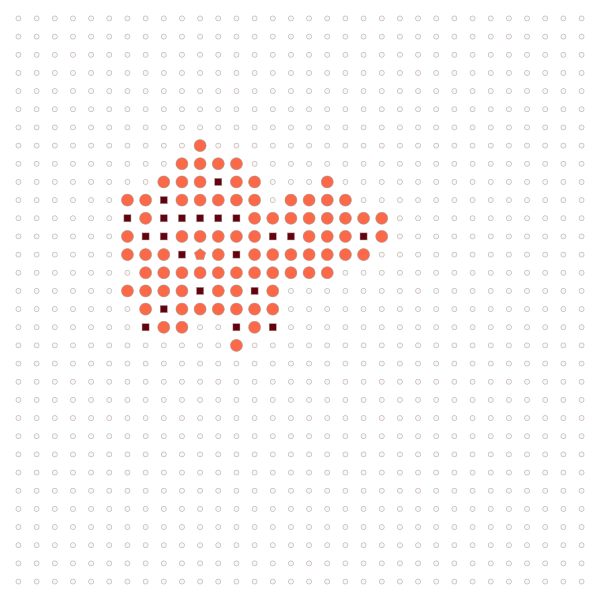

In [122]:
# plot cascade and observations

setting = default_plot_setting(g, c, obs)
visualize(g, pos, **setting)


In [123]:
query_method = 'entropy'
n_queries_to_show = 10

query_file_path = os.path.join(query_dir, query_method, '{}.pkl'.format(cascade_id))
proba_file_path = os.path.join(probas_dir, query_method, '{}.pkl'.format(cascade_id))
qs, _ = pkl.load(open(query_file_path, 'rb'))
qs = qs[:n_queries_to_show]
probas = pkl.load(open(proba_file_path, 'rb'))[:n_queries_to_show]

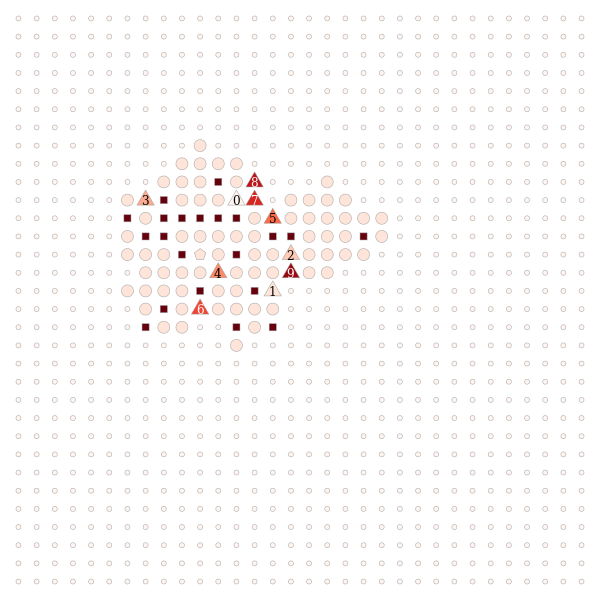

In [126]:
# plot the queries
s = query_plot_setting(g, c, obs, qs, indicator_type=['text', 'color'])
visualize(g, pos, **s)

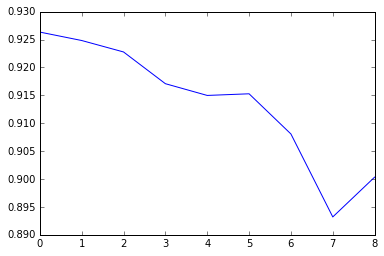

In [127]:
# plot the ap scores
ap_scores = get_ap_scores_by_queries(qs, probas, c, obs)
plt.plot(ap_scores)

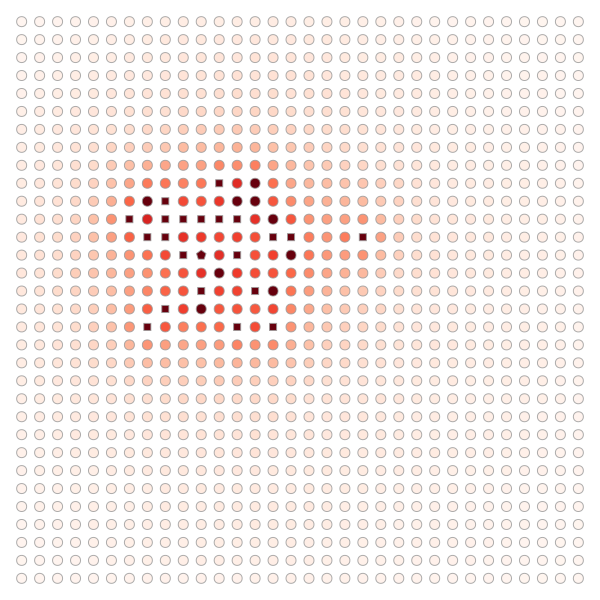

In [129]:
# plot the infection probability after queries
from viz_helpers import InfectionProbabilityViz

viz = InfectionProbabilityViz(g, pos)
hidden_infs = set(inf_nodes) - (set(obs) | set(qs))
def f(s):
    # s['node_size_info'][tuple(hidden_infs)] = 20
    pass
viz.plot(c, obs, probas[-1], f)